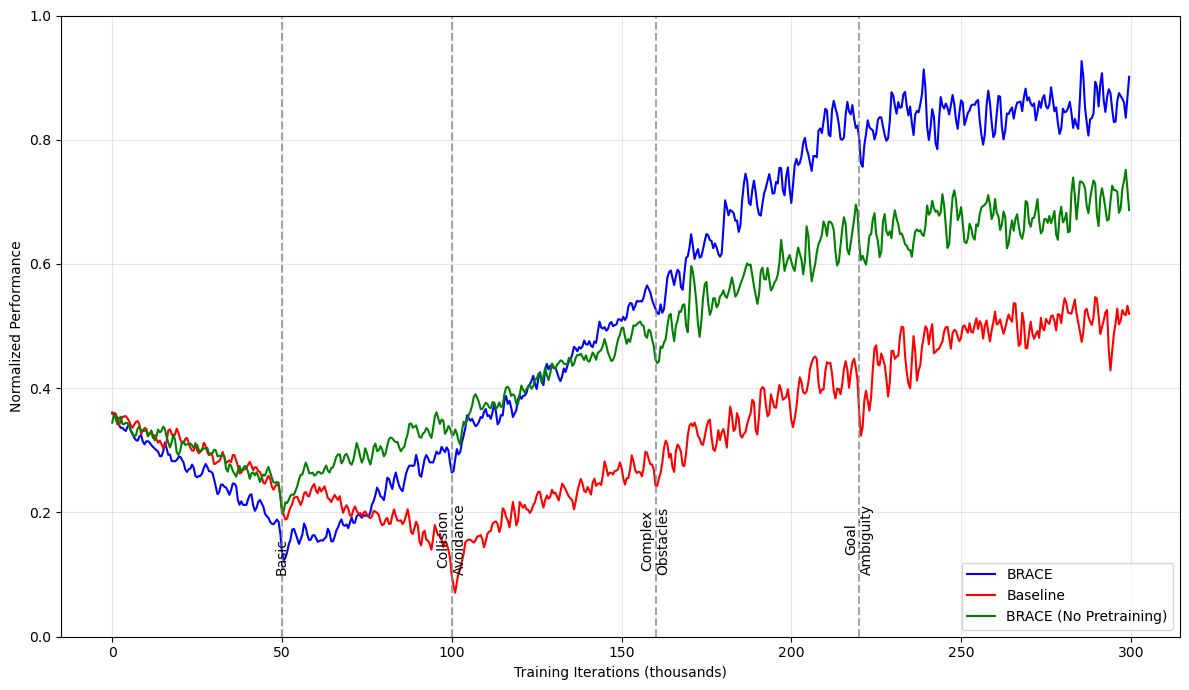

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Set random seed for reproducibility
np.random.seed(42)

# Define training iterations
iterations = 300000
# Increase resolution by generating more points (every 500 iterations instead of 1000)
x_axis = np.arange(0, iterations, 500)  

# Define curriculum stage transitions
curriculum_stages = {
    50000: "Basic",
    100000: "Collision\nAvoidance",
    160000: "Complex\nObstacles",
    220000: "Goal\nAmbiguity",
}

# Simulate normalized reward data for each approach with specific behaviors
def generate_reward_data(iterations, approach_type):
    """Generate simulated reward data based on approach type."""
    x = np.arange(0, iterations, 500)  # Increased resolution
    
    # Create a noise amplitude scaling factor with a jump after Complex Obstacles (160k)
    noise_scale = np.zeros_like(x, dtype=float)
    noise_scale[:] = np.linspace(0.3, 0.6, len(x))  # Base linear increase
    
    # Add a jump after Complex Obstacles
    complex_idx = x >= 160000
    noise_scale[complex_idx] = np.linspace(0.7, 1.0, sum(complex_idx))
    
    # Generate base noise components with more detail (higher frequency components)
    noise1 = np.random.normal(0, 0.03, size=len(x))  # Base noise
    noise2 = np.random.normal(0, 0.03, size=len(x)*5)  # Higher frequency noise
    noise2 = noise2[::5]  # Resample to match original dimension
    
    # Add even higher frequency components for more detail
    noise3 = np.random.normal(0, 0.015, size=len(x)*10)
    noise3 = noise3[::10]  # Resample
    
    # Combine noise components and apply progressive scaling
    noise = (noise1 + noise2 + noise3) * noise_scale[:, np.newaxis].reshape(-1)
    
    if approach_type == "brace":
        # BRACE: decreases until ~60k, then rises earlier than baseline
        base = np.zeros_like(x, dtype=float)
        
        # Initial value
        base[:] = 0.35
        
        # Initial downward trend until ~60k
        early_idx = x < 60000
        base[early_idx] = 0.35 - 0.2 * (x[early_idx] / 60000)
        
        # Rise after 60k
        rise_idx = (x >= 60000) & (x < 160000)
        base[rise_idx] = 0.15 + 0.4 * ((x[rise_idx] - 60000) / 100000)
        
        # Faster rise after Complex Obstacles (160k)
        boost_idx = (x >= 160000) & (x < 220000)
        base[boost_idx] = 0.55 + 0.3 * ((x[boost_idx] - 160000) / 60000)
        
        # Plateau at the end
        late_idx = x >= 220000
        base[late_idx] = 0.85
        
    elif approach_type == "no_pretraining":
        # No Pretraining: modify to have a more gradual increase
        base = np.zeros_like(x, dtype=float)
        
        # Start at same initial value as others
        base[:] = 0.35
        
        # Make the curve shape more gradual without sharp increases
        # Using multiple segments for more control over the shape
        segment1 = x < 50000
        segment2 = (x >= 50000) & (x < 100000)
        segment3 = (x >= 100000) & (x < 160000)
        segment4 = (x >= 160000) & (x < 220000)
        segment5 = x >= 220000
        
        # Initial slow progress
        base[segment1] = 0.35 - 0.1 * (x[segment1] / 50000)
        
        # Gradual improvement in Basic stage
        base[segment2] = 0.25 + 0.1 * ((x[segment2] - 50000) / 50000)
        
        # Continued improvement in Collision Avoidance
        base[segment3] = 0.35 + 0.15 * ((x[segment3] - 100000) / 60000)
        
        # Faster progress in Complex Obstacles
        base[segment4] = 0.5 + 0.15 * ((x[segment4] - 160000) / 60000)
        
        # Final performance
        base[segment5] = 0.65 + 0.05 * ((x[segment5] - 220000) / 80000)
        
    elif approach_type == "baseline":
        # Baseline: downward trend until 100k, then gradual increase
        base = np.zeros_like(x, dtype=float)
        
        # Initial value
        base[:] = 0.35
        
        # Downward trend until 100k
        early_idx = x < 100000
        base[early_idx] = 0.35 - 0.2 * (x[early_idx] / 100000)
        
        # Gradual increase after 100k
        rise_idx = (x >= 100000) & (x < 250000)
        base[rise_idx] = 0.15 + 0.35 * ((x[rise_idx] - 100000) / 150000)
        
        # Plateau at the end
        late_idx = x >= 250000
        base[late_idx] = 0.5
    
    # Add small performance drops after each curriculum stage
    # Define drop size based on approach
    if approach_type == "baseline":
        drop_size = 0.07  # Larger drop for baseline (red line)
    else:
        drop_size = 0.055  # Smaller drop for other approaches
        
    # Add drops at each transition point (with 5k step recovery)
    for transition in [50000, 100000, 160000, 220000]:
        # Find indices right after transition
        drop_idx = (x >= transition) & (x < transition + 5000)
        if np.any(drop_idx):
            # Create a recovery slope over 5k steps
            recovery = np.linspace(0, 1, sum(drop_idx))
            # Apply drop with recovery
            base[drop_idx] = base[drop_idx] - drop_size * (1 - recovery)
    
    # Add noise with progressively increasing amplitude
    performance = base + noise
    
    # Apply very light smoothing to preserve high-frequency components
    smoothed = gaussian_filter1d(performance, sigma=0.8)
    return smoothed

# Generate data for each approach
brace_rewards = generate_reward_data(iterations, "brace")
no_pretraining_rewards = generate_reward_data(iterations, "no_pretraining")
baseline_rewards = generate_reward_data(iterations, "baseline")

# Create the plot
plt.figure(figsize=(12, 7))

# Plot the reward curves
plt.plot(x_axis/1000, brace_rewards, 'b-', linewidth=1.5, label='BRACE')
plt.plot(x_axis/1000, baseline_rewards, 'r-', linewidth=1.5, label='Baseline')
plt.plot(x_axis/1000, no_pretraining_rewards, 'g-', linewidth=1.5, label='BRACE (No Pretraining)')

# Add vertical lines for curriculum stage transitions
for iteration, stage_name in curriculum_stages.items():
    plt.axvline(x=iteration/1000, color='gray', linestyle='--', alpha=0.7)
    plt.text(iteration/1000, 0.1, stage_name, rotation=90, verticalalignment='bottom', 
             horizontalalignment='center', fontsize=10)

# Set plot labels
plt.xlabel('Training Iterations (thousands)')
plt.ylabel('Normalized Performance')
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')

# Set y-axis limits for normalized performance
plt.ylim(0, 1)

plt.tight_layout()
plt.savefig('brace_normalized_comparison.png', dpi=300)
plt.show()